In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-localapprox-adaptive)=
# Adaptive integration

```{index} numerical integration
```

To this point, we have used only equally spaced nodes to compute integrals. Yet there are problems in which non-uniformly distributed nodes would clearly be more appropriate, as demonstrated in {numref}`Demo %s <demo-adapt-motive>`.

(demo-adapt-motive)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

This function gets increasingly oscillatory as $x$ increases.

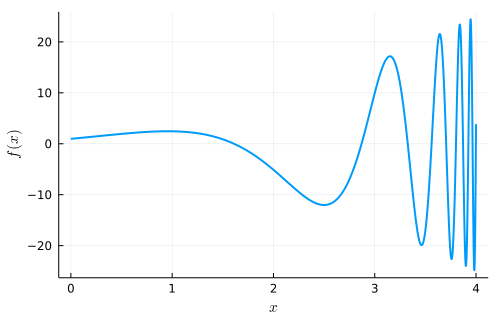

In [2]:
f = x -> (x+1)^2*cos((2*x+1)/(x-4.3))
plot(f,0,4,xlabel=L"x",ylabel=L"f(x)")

Accordingly, the trapezoid rule is more accurate on the left half of this interval than on the right half.

In [3]:
left_val,_ = quadgk(f,0,2,atol=1e-14,rtol=1e-14)
right_val,_ = quadgk(f,2,4,atol=1e-14,rtol=1e-14)

n = [ 50*2^k for k in 0:3 ]
left_err,right_err = [],[]
for n in n
    T,_ = FNC.trapezoid(f,0,2,n)
    push!(left_err,T-left_val)
    
    T,_ = FNC.trapezoid(f,2,4,n)
    push!(right_err,T-right_val)
end

pretty_table([n left_err right_err],["n" "left error" "right error"])

┌─────┬──────────────┬─────────────┐
│   n │   left error │ right error │
├─────┼──────────────┼─────────────┤
│  50 │  -0.00249106 │    0.504229 │
│ 100 │ -0.000622715 │   0.0960044 │
│ 200 │ -0.000155675 │   0.0225473 │
│ 400 │  -3.89187e-5 │  0.00555422 │
└─────┴──────────────┴─────────────┘


Both the picture and the numerical results suggest that more nodes should be used on the right half of the interval than on the left half.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

We would like an algorithm that automatically detects and reacts to a situation like that in {numref}`Demo %s <demo-adapt-motive>`, a trait known as **adaptivity**.

## Error estimation

```{index} Simpson's formula
```

Ideally, we would like to make adaptation decisions based on the error of the integration result. Knowing the error exactly would be equivalent to knowing the exact answer, but we can estimate it using the extrapolation technique of {numref}`section-localapprox-integration`. Consider the Simpson formula {eq}`extraplevel1` resulting from one level of extrapolation from trapezoid estimates:

```{math}
  :label: extraplevel1repeat
  S_f(2n) = \frac{1}{3} \Bigl[ 4 T_f(2n) - T_f(n) \Bigr].
```

We expect this method to be fourth-order accurate, i.e.,

```{math}
  \int_a^b f(x)\, dx = S_f(2n) + O(n^{-4}),
```

We can further extrapolate to sixth-order accuracy using {eq}`nc-sixth`:

```{math}
  :label: extraplevel2repeat
  R_f(4n) = \frac{1}{15} \Bigl[ 16 S_f(4n) - S_f(2n) \Bigr].
```

By virtue of higher order of accuracy, $R_f(4n)$ should be more accurate than $S_f(4n)$. Hence a decent estimate of the error in the better of the two Simpson values is

```{math}
  :label: adapterr
  E = R_f(4n) - S_f(4n) = \frac{S_f(4n) - S_f(2n)}{15}.
```

```{index} adaptivity; in integration, divide and conquer
```

## Divide and conquer

If $|E|$ is judged to be acceptably small, we are done. This judgment takes some care. For instance, suppose the exact integral is $10^{20}$.  Requiring $|E| < \delta\ll 1$ would be fruitless in double precision, since it would require more than 20 accurate digits. Hence checking the absolute size of the error alone is not appropriate. Conversely, consider the integral

```{math}
  \int_{10^{-6}}^{2\pi} 2 \sin x\, dx \approx -10^{-12}.
```

We are likely to sample values of the integrand that are larger than, say, $1/2$ in absolute value, so obtaining this very small result has to rely on subtractive cancellation. We cannot hope for more than 4-5 accurate digits, so a strict test of the relative error is also not recommended. In other words, we can seek an error that is small relative to the data (the integrand), which is $O(1)$, but not relative to the answer itself. 

Typically we use both relative and absolute error, stopping when either one is considered small enough. Algebraically, the test is

```{math}
  :label: absreltolerance
  |E| < \delta_a + \delta_r |S_f(n)|,
```

where $\delta_a$ and $\delta_r$ are given absolute and relative error tolerances, respectively.

When $|E|$ fails to meet {eq}`absreltolerance`, we bisect the interval $[a,b]$ to exploit the identity

```{math}
  \int_a^b f(x)\, dx = \int_a^{(a+b)/2} f(x)\, dx + \int_{(a+b)/2}^b f(x)\, dx,
```

and independently compute estimates to each of the half-length integrals. Each of these half-sized computations recursively applies Simpson's formula and the error estimation criterion, making further bisections as necessary. Such an approach is called **divide and conquer** in computer science: recursively split the problem into easier pieces and glue the results together.

## Implementation

It is typical to use just the minimal formula $S_f(4)$ and its error estimate $E$ to make decisions about adaptivity. A computation of $S_f(4)$ requires three trapezoid estimates $T_f(1)$, $T_f(2)$, and $T_f(4)$. As observed in {eq}`nc-doubling` and {numref}`Demo %s <demo-int-extrap>`, the five integrand evaluations in $T_f(4)$ are sufficient to compute all of these values.

{numref}`Function {number} <function-intadapt>` shows an implementation. It uses five function values to compute three trapezoid estimates with $n=1$, $n=2$, and $n=4$, applying the updating formula {eq}`nc-doubling` twice. It goes on to find the two Simpson approximations and to estimate the error by {eq}`adapterr`.

If the error estimate passes the test {eq}`absreltolerance`, the better Simpson value is returned as the integral over the given interval. Otherwise, the interval is bisected, integrals over the two pieces are computed using recursive calls, and those results are added to give the complete integral.

```{index} Julia; keyword function arguments
```

(function-intadapt)=

````{proof:function} intadapt
**Adaptive integration with error estimation**

```{code-block} julia1
:lineno-start: 1
"""
    intadapt(f,a,b,tol)

Adaptively integrate `f` over [`a`,`b`] to within target error 
tolerance `tol`. Returns the estimate and a vector of evaluation 
nodes.
"""
function intadapt(f,a,b,tol,fa=f(a),fb=f(b),m=(a+b)/2,fm=f(m))
    # Use error estimation and recursive bisection.
    # These are the two new nodes and their f-values.
    xl = (a+m)/2;  fl = f(xl);
    xr = (m+b)/2;  fr = f(xr);
    
    # Compute the trapezoid values iteratively.
    h = (b-a)
    T = [0.,0.,0.]
    T[1] = h*(fa+fb)/2
    T[2] = T[1]/2 + (h/2)*fm
    T[3] = T[2]/2 + (h/4)*(fl+fr)
    
    S = (4T[2:3]-T[1:2]) / 3      # Simpson values
    E = (S[2]-S[1]) / 15           # error estimate
    
    if abs(E) < tol*(1+abs(S[2]))  # acceptable error?
        Q = S[2]                   # yes--done
        nodes = [a,xl,m,xr,b]      # all nodes at this level
    else
        # Error is too large--bisect and recurse.
        QL,tL = intadapt(f,a,m,tol,fa,fm,xl,fl)
        QR,tR = intadapt(f,m,b,tol,fm,fb,xr,fr)
        Q = QL + QR
        nodes = [tL;tR[2:end]]   # merge the nodes w/o duplicate
    end
    return Q,nodes
end
```
````

:::{admonition} About the code
:class: dropdown
The intended way for a user to call {numref}`Function {number} <function-intadapt>` is with only `f`, `a`, `b`, and `tol` provided. We then use default values on the other parameters to compute the function values at the endpoints, the interval's midpoint, and the function value at the midpoint. Recursive calls from within the function itself will provide all of that information, since it was already calculated along the way.
:::

(demo-adapt-usage)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We'll integrate the function from {numref}`Demo %s <demo-adapt-motive>`.

In [4]:
f = x -> (x+1)^2*cos((2*x+1)/(x-4.3));

We perform the integration and show the nodes selected underneath the curve.

num_nodes = length(t) = 69


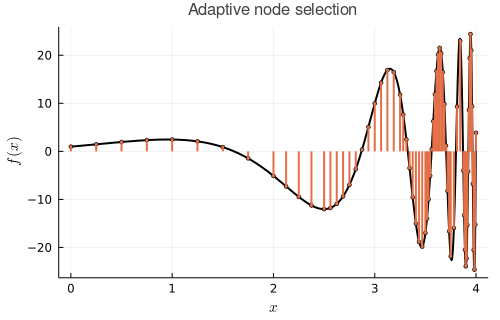

In [5]:
A,t = FNC.intadapt(f,0,4,0.001)
@show num_nodes = length(t);

plot(f,0,4,color=:black,legend=:none,
    xlabel=L"x",ylabel=L"f(x)",title="Adaptive node selection")
plot!(t,f.(t),seriestype=:sticks,m=(:o,2))

The error turns out to be a bit more than we requested. It's only an estimate, not a guarantee.

In [6]:
Q,_ = quadgk(f,0,4,atol=1e-14,rtol=1e-14);    # 'exact' value
println("error: $(Q-A)");

error: -0.022002813037627078


Let's see how the number of integrand evaluations and the error vary with the requested tolerance.

In [7]:
tol = [ 1/10^k for k in 4:14 ]
err,n = [],[]
for tol in 10.0.^(-4:-1:-14)
    A,t = FNC.intadapt(f,0,4,tol)
    push!(err,Q-A)
    push!(n,length(t))
end

pretty_table([tol err n],["tolerance","error","number of nodes"])

┌───────────┬──────────────┬─────────────────┐
│ tolerance │        error │ number of nodes │
├───────────┼──────────────┼─────────────────┤
│    0.0001 │ -0.000419469 │             113 │
│    1.0e-5 │   4.78977e-5 │             181 │
│    1.0e-6 │   6.31438e-6 │             297 │
│    1.0e-7 │  -6.63925e-7 │             489 │
│    1.0e-8 │   7.18081e-8 │             757 │
│    1.0e-9 │   1.26524e-8 │            1193 │
│   1.0e-10 │ -8.44126e-10 │            2009 │
│   1.0e-11 │  2.61271e-11 │            3157 │
│   1.0e-12 │  4.04463e-11 │            4797 │
│   1.0e-13 │ -1.93712e-12 │            7997 │
│   1.0e-14 │  1.62981e-13 │           12609 │
└───────────┴──────────────┴─────────────────┘


As you can see, even though the errors are not smaller than the estimates, the two columns decrease in tandem. If we consider now the convergence not in $h$, which is poorly defined now, but in the number of nodes actually chosen, we come close to the fourth-order accuracy of the underlying Simpson scheme.

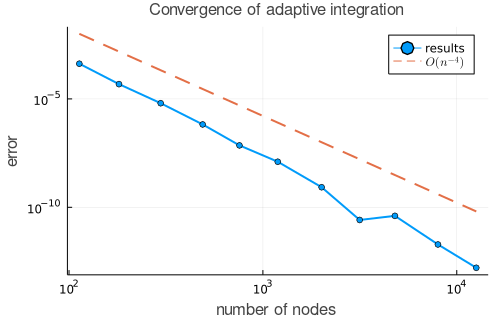

In [8]:
plot(n,abs.(err),m=:o,label="results",
    xaxis=(:log10,"number of nodes"),yaxis=(:log10,"error"),
    title="Convergence of adaptive integration")

order4 = @. 0.01*(n/n[1])^(-4)
plot!(n,order4,l=:dash,label=L"O(n^{-4})")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Although adaptivity and the error estimation that goes with it can be very powerful, they come at some cost. The error estimation cannot be universally perfect, so sometimes the answer will not be as accurate as requested, and sometimes the function will be evaluated more times than necessary. Subtle problems may arise when the integral is a step within a larger computation (see [Exercise 6](problem-adaptive-nonsmooth)).

## Exercises

(problem-adaptquadtests)=
% must be kept as #1

1. ⌨ For each integral below, use {numref}`Function {number} <function-intadapt>` with error tolerance $10^{-2},10^{-3},\ldots,10^{-12}$. Make a table of errors and the number of integrand evaluation nodes used, and use a convergence plot as in {numref}`Demo %s <demo-adapt-usage>` to compare to fourth-order accuracy. (These integrals were taken from {cite}`baileyComparisonThree2005`.)

    **(a)** $\displaystyle \int_0^1 x\log(1+x)\, dx = \frac{1}{4}$

    **(b)** $\displaystyle \int_0^1 x^2 \tan^{-1}x\, dx = \frac{\pi-2+2\log 2}{12}$

    **(c)** $\displaystyle \int_0^{\pi/2}e^x \cos x\, dx = \frac{e^{\pi/2}-1}{2}$

    **(d)** $\displaystyle \int_{0}^1 \sqrt{x} \log(x) \, dx = -\frac{4}{9}$ (Note: Although the integrand has the limiting value zero as $x\to 0$, you have to implement the function carefully to return zero as the value of $f(0)$, or start the integral at $x=\macheps$.)

    **(e)** $\displaystyle \int_0^1 \sqrt{1-x^2}\, dx = \frac{\pi}{4}$

2. ⌨ For each integral below: (i) use `quadgk` to find the value to at least 12 digits; (ii) use {numref}`Function {number} <function-intadapt>` to evaluate the integral to a tolerance of $10^{-8}$; (iii) compute the absolute error and the number of nodes used; (iv) use the $O(h^2)$ term in the Euler–Maclaurin formula {eq}`eulermaclaurin` to estimate how many nodes are required by the fixed-stepsize trapezoidal formula to reach an absolute error of $10^{-8}$.

    **(a)** $\displaystyle \int_{0.1}^3 \operatorname{sech}(\sin(1/x))\, d x$

    **(b)** $\rule[2em]{0pt}{0pt} \displaystyle\int_{-0.9}^9 \ln((x+1)^3))\, d x$

    **(c)** $\rule[2em]{0pt}{0pt} \displaystyle\int_{-\pi}^\pi \cos(x^3)\, d x$

    ```{index} improper integral
    ```    
3. ⌨ An integral such as $\displaystyle \int_0^1 x^{-\gamma}\, dx$ for $\gamma>0$, in which the integrand blows up at one or both ends, is known as an *improper* integral. It has a finite value if $\gamma<1$, despite the singularity. One way to deal with the problem of the infinite value for $f(t_0)$ is to replace the lower limit with a small number $\epsilon$. (A more robust way to handle improper integrals is discussed in Chapter 9.)
    
    Using {numref}`Function {number} <function-intadapt>` with a small tolerance, make a log-log plot of the error as a function of $\epsilon$ when $\gamma=2/3$, for $\epsilon=10^{-15},10^{-16},\ldots,10^{-45}$. 

4. ⌨ A curious consequence of our logic in {numref}`Function {number} <function-intadapt>` is that the algorithm uses what we believe to be a more accurate, sixth-order answer only for estimating error; the returned value is the supposedly less accurate $S_f(2n)$. The practice of returning the extrapolated $R_f(4n)$ instead is called *local extrapolation*. 
    
    Modify {numref}`Function {number} <function-intadapt>` to use local extrapolation and repeat parts (a) and (e) of Exercise 1 above, comparing the observed convergence to both fourth order and sixth order.


    ```{index} sine integral function
    ```   
5. ⌨ The *sine integral function* is defined by
  
    ```{math}
    \operatorname{Si}(x) = \int_0^x \frac{\sin z}{z}\, dz.
    ```

    Use {numref}`Function {number} <function-intadapt>` to plot Si over the interval $[1,10]$. Note: You will need to replace the lower bound of integration by $\macheps$.


    (problem-adaptive-nonsmooth)=
6. ⌨  Adaptive integration can have subtle drawbacks. This exercise is based on the *error function*, a smooth function defined as
  
    ```{math}
    \operatorname{erf}(x) = \frac{2}{\sqrt{\pi}}\int_0^x e^{-s^2}\,ds.
    ```

    **(a)** Define a function $g$ that approximates erf by applying {numref}`Function {number} <function-trapezoid>` with $n=300$. Make a plot of the error $g(x)-\operatorname{erf}(x)$ at 500 points in the interval $[0,3]$.

    **(b)** Define another approximation $h$ that applies {numref}`Function {number} <function-intadapt>` with error tolerance $10^{-7}$. Plot the error in $h$ as in part (a). Why does it look so different from the previous case?

    **(c)** Suppose you wished to find $x$ such that $\operatorname{erf}(x) = .95$ by using rootfinding on one of your two approximations. Why is the version from part (a) preferable?